# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Traffic Sign Recognition Classifier

In this notebook, a ConvNet is trained to recognize traffic signs in the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).  The project is organized into 3 steps:

1. Dataset Summary & Exploration
2. Design and Test a Model Architecture
3. Test the Model on New Images

This notebook is available as both an [iPython Notebook](https://github.com/patrick-klein/CarND-Traffic-Sign-Classifier-Project/blob/master/Traffic_Sign_Classifier.ipynb) and [HTML document](https://github.com/patrick-klein/CarND-Traffic-Sign-Classifier-Project/blob/master/Traffic_Sign_Classifier.html), per project guidelines.  Also included is a [writeup](https://github.com/patrick-klein/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup.md) that explicitly addresses the requirements in the [project rubric](https://review.udacity.com/#!/rubrics/481/view).

All code has been tested on macOS 10.13 and an AWS instance.  The *carnd-term1* environment is required.

---
## Step 0: Load The Data

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [249]:
# Load pickled data
import pickle
from sklearn.utils import shuffle

# Path to data files
training_file = 'data/train.p'
validation_file='data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

### Basic Summary of the Dataset

In [250]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples
n_test = len(X_test)

# Shape of a traffic sign image
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

A random image from the dataset is displayed, in order to demonstrate the data has been loaded and the typical quality of the images.

9


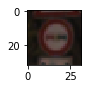

In [251]:
### Display a random image from the training data

import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, n_train)
image = X_train[index].squeeze()

print(y_train[index])
plt.figure(figsize=(1,1))
plt.imshow(image)

Histograms for the labels data are displayed to demonstrate the relative distributions of traffic signs in the training, testing, and validation datasets.

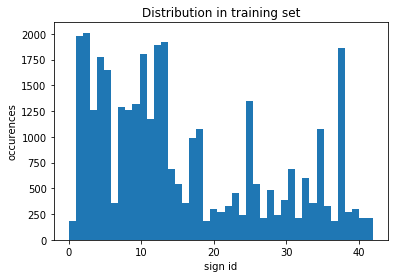

In [252]:
_ = plt.hist(y_train,bins=n_classes)
plt.title('Distribution in training set')
plt.xlabel('sign id')
plt.ylabel('occurences')

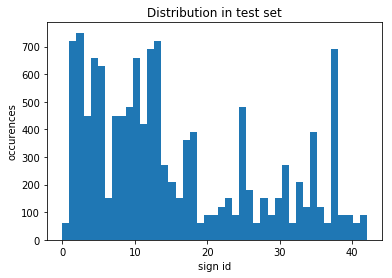

In [253]:
_ = plt.hist(y_test,bins=n_classes)
plt.title('Distribution in test set')
plt.xlabel('sign id')
plt.ylabel('occurences')

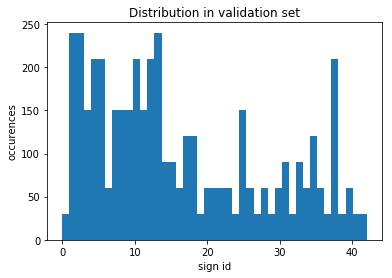

In [254]:
_ = plt.hist(y_valid,bins=n_classes)
plt.title('Distribution in validation set')
plt.xlabel('sign id')
plt.ylabel('occurences')

### Augment the Dataset

The training data is augmented in order to increase robustness against minor variances.  This includes duplicating the dataset with small variations in noise, rotation, and blur.  These effects are applied independently to one another.

Augmentation techniques inspired by [Traffic Sign Recognition with Multi-Scale Convolutional Networks](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf)

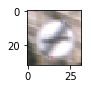

In [255]:
# Display a reference image

plt.figure(figsize=(1,1))
plt.imshow(X_train[50].squeeze())

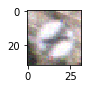

In [256]:
### Add noise to training images

X_train_noise = np.zeros_like(X_train)
for i, x in enumerate(X_train):
    X_train_noise[i] = np.clip(X_train[i]+10*np.random.randn(32,32,3),0,255)    # adds +/- 10 to each color channel for each pixel (not just intensity)

# Show effect on reference image
plt.figure(figsize=(1,1))
plt.imshow(X_train_noise[50].squeeze())

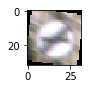

In [257]:
### Rotate training images by small angle

from scipy.ndimage.interpolation import rotate

X_train_rotate = np.zeros_like(X_train)
for i, x in enumerate(X_train):
    X_train_rotate[i] = rotate(X_train[i],15*np.random.randn(), reshape=False)    # up to 15 deg

# Show effect on reference image
plt.figure(figsize=(1,1))
plt.imshow(X_train_rotate[50].squeeze())

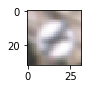

In [258]:
### Blur training images by small amount

from scipy.ndimage import gaussian_filter

X_train_blur = np.zeros_like(X_train)
for i, x in enumerate(X_train):
    X_train_blur[i] = gaussian_filter(X_train[i], sigma=(1, 1, 0), order=0)    # smallest kernel

# Show effect on reference image
plt.figure(figsize=(1,1))
plt.imshow(X_train_blur[50].squeeze())

In [259]:
# Append X_train with the perturbed images.
X_train = np.append(X_train,X_train_noise,axis=0)
X_train = np.append(X_train,X_train_rotate,axis=0)
X_train = np.append(X_train,X_train_blur,axis=0)

# Copy label data for each data augmentation in X
y_train = np.tile(y_train,4)

----

## Step 2: Design and Test a Model Architecture

The deep learning model used to recognize traffic signs is a convolutional neural net based on the LeNet-5 architecture demonstrated during the [Udacity lectures](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81).

Techniques in this section are mainly inspired by [Traffic Sign Recognition with Multi-Scale Convolutional Networks](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf)

### Tensorflow Pre-processing

The following pre-processing is applied to every batch/image before being run through the ConvNet

In [260]:
import tensorflow as tf

# Convert RGB image to grayscale
def grayscale(x):
    x = tf.image.rgb_to_grayscale(x)
    return(x)

# Normalize image
def normalize(x):
    x = (x-128)/128
    return(x)

# Apply pre-processing to each image
def preprocess(x):
    x = grayscale(x)
    x = normalize(x)
    return(x)

### Model Architecture

The following model is called during training and testing to calculate the logits for the pre-processed image/batch.  A detailed breakdown of the ConvNet is included in the writeup.

In [261]:
from tensorflow.contrib.layers import flatten

EPOCHS = 10
BATCH_SIZE = 128

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    W_1 = tf.Variable(tf.truncated_normal([5, 5, 1, 6], mean=mu, stddev=sigma))
    b_1 = tf.Variable(tf.zeros([6]))
    layer1_conv = tf.nn.conv2d(x, W_1, strides=[1, 1, 1, 1], padding='VALID') + b_1

    # Activation.
    layer1_relu = tf.nn.relu(layer1_conv)
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    layer1_pool = tf.nn.max_pool(layer1_conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 2: Convolutional. Output = 10x10x16.
    W_2 = tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean=mu, stddev=sigma))
    b_2 = tf.Variable(tf.zeros([16]))
    layer2_conv = tf.nn.conv2d(layer1_pool, W_2, strides=[1, 1, 1, 1], padding='VALID') + b_2
    
    # Activation.
    layer2_relu = tf.nn.relu(layer2_conv)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    layer2_pool = tf.nn.max_pool(layer2_relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    layer2_flat = flatten(layer2_pool)
    
    # Flatten. Input = 10x10x16. Output = 1176.
    layer1_flat = flatten(layer1_pool)
    
    # Concatenate. Input = 400+1176.  Output = 1576.
    #layer2_cat = tf.concat([layer1_flat, layer2_flat],1)       # only use in TensorFlow v1.0+
    layer2_cat = tf.concat_v2([layer1_flat, layer2_flat],1)
    
    # Layer 3: Fully Connected. Input = 1576. Output = 120.
    W_3 = tf.Variable(tf.truncated_normal([1576, 120], mean=mu, stddev=sigma))
    b_3 = tf.Variable(tf.zeros([120]))
    layer3_fc = tf.add(tf.matmul(layer2_cat,W_3),b_3)
    
    #tf.nn.batch_normalization
    
    # Activation.
    layer3_relu = tf.nn.relu(layer3_fc)
    
    # Dropout.
    layer3_drop = tf.nn.dropout(layer3_relu, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    W_4 = tf.Variable(tf.truncated_normal([120, 84], mean=mu, stddev=sigma))
    b_4 = tf.Variable(tf.zeros([84]))
    layer4_fc = tf.add(tf.matmul(layer3_drop,W_4),b_4)
    
    # Batch Normalization.
    #layer4_mean, layer4_var = tf.nn.moments(layer4_fc,[0])
    #layer4_beta = tf.Variable(tf.zeros([84]))
    #layer4_scale = tf.Variable(tf.ones([84]))
    #layer4_bn = tf.nn.batch_normalization(layer4_fc,layer4_mean,layer4_var,layer4_beta,layer4_scale,1e-3)
    
    # Activation.
    layer4_relu = tf.nn.relu(layer4_fc)
    
    # Dropout.
    layer4_drop = tf.nn.dropout(layer4_relu, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    W_5 = tf.Variable(tf.truncated_normal([84, 43], mean=mu, stddev=sigma))
    b_5 = tf.Variable(tf.zeros([43]))
    layer5_fc = tf.add(tf.matmul(layer4_drop,W_5),b_5)
    
    logits = layer5_fc
    
    return logits

### Train, Validate and Test the Model

In [262]:
### Set up TensorFlow for training & testing

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

rate = 0.001

logits = LeNet(preprocess(x))
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [263]:
### Train the model

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.892

EPOCH 2 ...
Validation Accuracy = 0.923

EPOCH 3 ...
Validation Accuracy = 0.927

EPOCH 4 ...
Validation Accuracy = 0.941

EPOCH 5 ...
Validation Accuracy = 0.951

EPOCH 6 ...
Validation Accuracy = 0.952

EPOCH 7 ...
Validation Accuracy = 0.951

EPOCH 8 ...
Validation Accuracy = 0.951

EPOCH 9 ...
Validation Accuracy = 0.961

EPOCH 10 ...
Validation Accuracy = 0.953

Model saved


In [264]:
# Test the model (Only run once!)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    train_accuracy = evaluate(X_train, y_train)
    print("Training Accuracy = {:.3f}".format(train_accuracy))
    valid_accuracy = evaluate(X_valid, y_valid)
    print("Validation Accuracy = {:.3f}".format(valid_accuracy))
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Training Accuracy = 0.983
Validation Accuracy = 0.953
Test Accuracy = 0.935


---

## Step 3: Test the Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

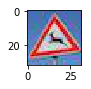

In [265]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

import matplotlib.image as mpimg


test_img = np.ndarray([5,32,32,3], dtype='uint8')
test_id = np.array([4,31,2,13,1])

test_img[0] = mpimg.imread('test/test1.jpg') #70
test_img[1] = mpimg.imread('test/test2.jpg') #wildlife
test_img[2] = mpimg.imread('test/test3.jpg') #50
test_img[3] = mpimg.imread('test/test4.jpg') #yield
test_img[4] = mpimg.imread('test/test5.jpg') #30

plt.figure(figsize=(1,1))
plt.imshow(test_img[1])


### Predict the Sign Type for Each Image

In [266]:
### Run the predictions here and use the model to output the prediction for each image.

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    out = sess.run(tf.nn.softmax(logits), feed_dict={x: test_img, keep_prob: 1.0})
    
pred = np.argmax(out,1)
print(pred)

# 1,  31,       60, 13,    1
# 30, wildlife, 50, yield, 30

[ 1 31  3 13  1]


### Analyze Performance

In [280]:
### Calculate the accuracy for these 5 new images

acc = np.sum(np.equal(test_id,pred))/5
print(acc)

0.6


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [274]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web 

with tf.Session() as sess:
    top_k_out = sess.run(tf.nn.top_k(tf.constant(out), k=5))

print(top_k_out.values)
print(top_k_out.indices)

[[  9.93119955e-01   5.50289499e-03   1.24849682e-03   1.13472590e-04
    1.48618119e-05]
 [  9.77290392e-01   2.27071494e-02   1.80642212e-06   5.01864577e-07
    1.25114482e-07]
 [  5.88173568e-01   2.63476551e-01   1.00564748e-01   1.65310744e-02
    9.16190259e-03]
 [  1.00000000e+00   1.56127206e-27   7.37923108e-36   7.41056761e-37
    3.15286437e-38]
 [  9.99740303e-01   2.49255565e-04   1.04647397e-05   1.28851925e-08
    1.17133636e-08]]
[[ 1 18  4  0 11]
 [31 23 10 21 19]
 [ 3  1  5  2 33]
 [13 12 15 38 35]
 [ 1  0  4  5  2]]


<Container object of 5 artists>

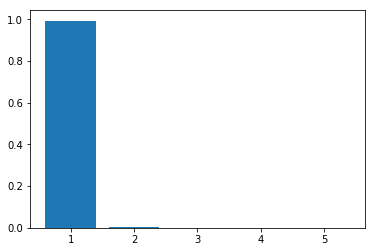

In [275]:
plt.bar([1,2,3,4,5],top_k_out.values[0])

<Container object of 5 artists>

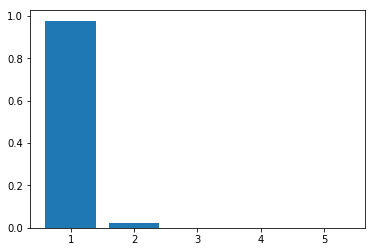

In [276]:
plt.bar([1,2,3,4,5],top_k_out.values[1])

<Container object of 5 artists>

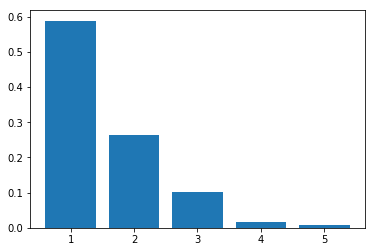

In [277]:
plt.bar([1,2,3,4,5],top_k_out.values[2])

<Container object of 5 artists>

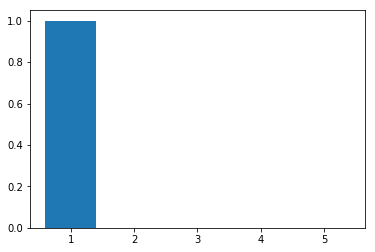

In [278]:
plt.bar([1,2,3,4,5],top_k_out.values[3])

<Container object of 5 artists>

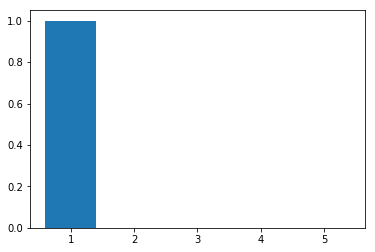

In [279]:
plt.bar([1,2,3,4,5],top_k_out.values[4])